In [10]:
library(Seurat)
library(patchwork)
library(tidyverse)
library(dplyr)

In [12]:
DATA_DIR = "/blue/mateescu/lihe.liu/scRNA/data/seq"

In [ ]:
BC2_path = file.path(DATA_DIR, "s4","BC2")
# BC21_path = file.path(DATA_DIR, "s4","BC21")
#
reads_BC2=Read10X(BC2_path)
seurat_BC2 = CreateSeuratObject(reads_BC2,
                           min.cells = 3,
                           project="sampl.1", 
                           min.features = 40)
#
# reads_BC21=Read10X(BC21_path)
# seurat_BC21 = CreateSeuratObject(reads_BC21,
#                             min.cells = 3,
#                             project="sampl.2", 
#                             min.features = 40)
#   

In [44]:
## calculate the percentage of mitochondrial genes
seurat_BC2@meta.data$per.mt=PercentageFeatureSet(seurat_BC2, pattern = "^MT-")
# seurat_BC2[["percent.mt"]] = PercentageFeatureSet(seurat_BC2, pattern = "^MT-") # will achieve the same result

In [64]:
# calculate the percentage of red blood cell genes
HB.genes = c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
HB_m = match(HB.genes, rownames(seurat_BC2@assays$RNA))
HB.genes = rownames(seurat_BC2@assays$RNA)[HB_m] 
HB.genes = HB.genes[!is.na(HB.genes)] 
seurat_BC2[["percent.HB"]]<-PercentageFeatureSet(seurat_BC2, features=HB.genes) 
head(seurat_BC2@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,per.mt,percent.HB
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACCTGAGATCCCGC-1,sampl.1,1227,620,4.9714751,0
AAACCTGCAGGAATCG-1,sampl.1,1180,670,3.1355932,0
AAACCTGGTACACCGC-1,sampl.1,825,450,3.2727273,0
AAACCTGGTACGCACC-1,sampl.1,1618,788,5.5006180,0
AAACCTGGTAGAAGGA-1,sampl.1,1032,610,4.1666667,0
AAACCTGGTCGCGTGT-1,sampl.1,1017,472,0.5899705,0


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


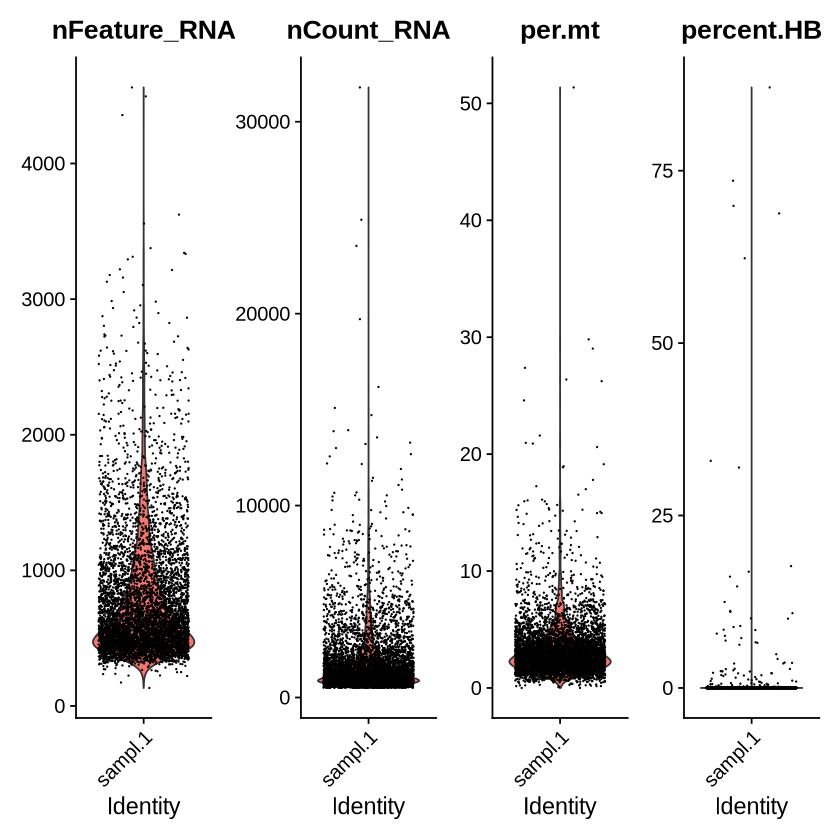

In [73]:
# check the distribution of the percentage of mitochondrial genes & more
violin <- VlnPlot(seurat_BC2,
                  features = c("nFeature_RNA", "nCount_RNA",
                               "per.mt","percent.HB"), 
                  pt.size = 0.01,
                  ncol = 4) 
violin 

In [77]:
# check the correlation between these features
plot1 = FeatureScatter(seurat_BC2, feature1 = "nCount_RNA", feature2 = "per.mt")
plot2 = FeatureScatter(seurat_BC2, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 = FeatureScatter(seurat_BC2, feature1 = "nCount_RNA", feature2 = "percent.HB")

Warning message in CombinePlots(plots = list(plot1, plot2, plot3), nrow = 2, legend = "none"):
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


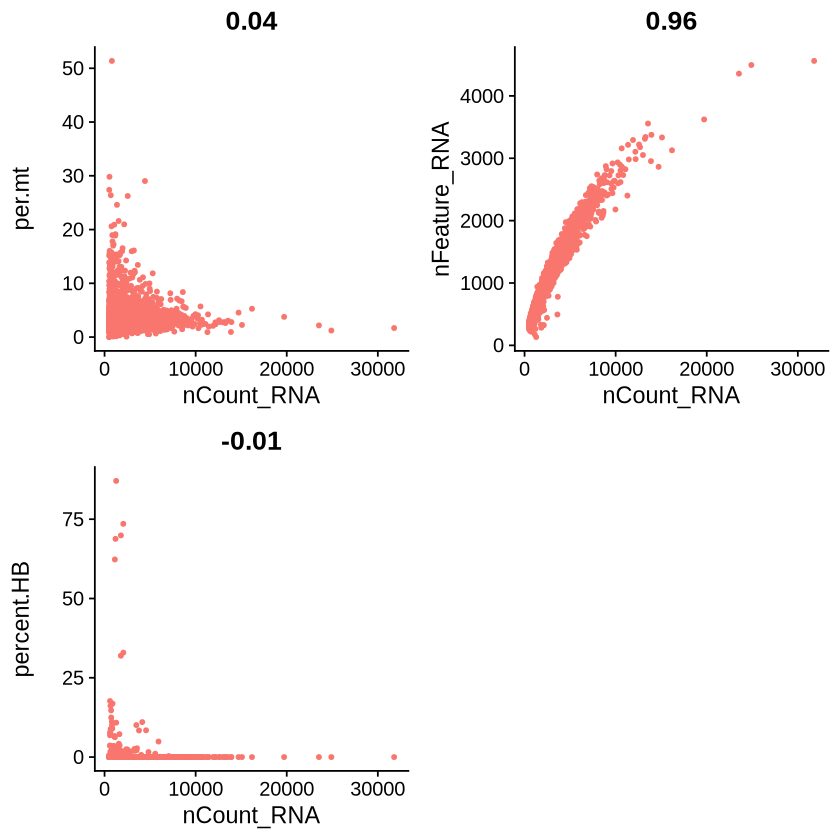

In [93]:
CombinePlots(plots = list(plot1, plot2, plot3), nrow=2, legend="none") 

In [100]:
# filtering
seurat_BC2_process = subset(seurat_BC2, subset = nFeature_RNA > 500 & per.mt < 20 & percent.HB < 1 & nCount_RNA > 1000)

# normalization
seurat_BC2_process <- NormalizeData(seurat_BC2_process,
                        normalization.method = "LogNormalize", 
                        scale.factor = 10000)

# find high variable genes
seurat_BC2_process <- FindVariableFeatures(seurat_BC2_process,
                                            selection.method = "vst", 
                                            nfeatures = 2000)  

Normalizing layer: counts

Finding variable features for layer counts



When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


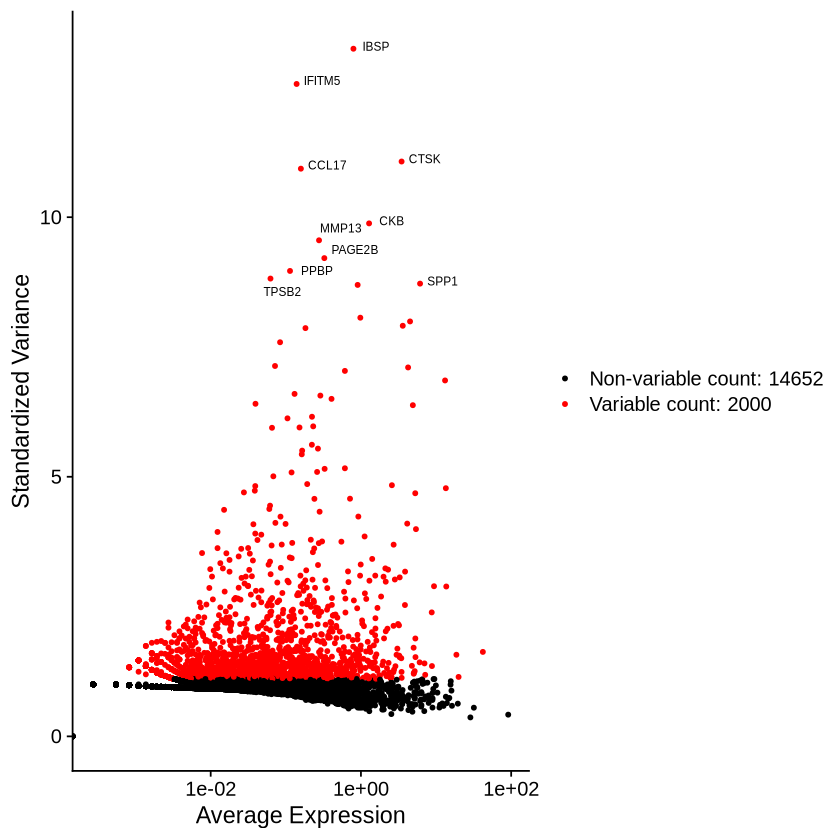

In [106]:
# Identify the 10 most highly variable genes for plotting
top10_gene = head(VariableFeatures(seurat_BC2_process), 10) 
# plot variable features with and without labels
ptop10_gene_plt = VariableFeaturePlot(seurat_BC2_process) 
ptop10_gene_label = LabelPoints(plot = ptop10_gene_plt, points = top10_gene, repel = TRUE, size=2.5)
ptop10_gene_label

In [ ]:
# scaling
scale.genes =  rownames(seurat_BC2_process)
seurat_BC2_process = ScaleData(seurat_BC2_process, features = scale.genes)


Centering and scaling data matrix



PC_ 1 
Positive:  SPARC, COL1A1, COL1A2, CALD1, COL3A1, NNMT, COL5A2, LUM, TPM1, PCOLCE 
	   TPM2, MYL9, TAGLN, FN1, POSTN, IGFBP7, BGN, SERPINH1, CNN3, CTHRC1 
	   COL6A2, COL6A3, SELENOM, MDK, FSTL1, TIMP1, THY1, COL6A1, CTGF, ACTA2 
Negative:  HLA-DRA, CD74, FTL, APOC1, HLA-DPB1, HLA-DPA1, LYZ, NPC2, APOE, CCL3 
	   C1QA, C1QB, CCL3L1, C1QC, CD14, CTSD, CD68, MS4A6A, CXCL8, GLUL 
	   RGS1, FTH1, CCL4, GPR183, CCL4L2, CTSB, CXCL3, MS4A4A, ACP5, CD163 
PC_ 2 
Positive:  SPARCL1, IFI27, IGFBP7, RAMP2, VWF, COL4A1, GNG11, COL15A1, HSPG2, PCDH17 
	   PLVAP, RAMP3, MGP, ADGRL4, SPRY1, AQP1, EGFL7, ECSCR, PECAM1, CD93 
	   TM4SF1, A2M, EMCN, ACKR1, APLNR, TCF4, FAM167B, CRIP2, PDLIM1, CALCRL 
Negative:  MMP9, CTSK, CKB, ACP5, RGS10, SLC9B2, PAGE2B, ATP6V0B, SPP1, PAGE2 
	   CST3, ATP6V1B2, SNX10, ATP5MC3, SIGLEC15, GAGE1, NDUFS8, ATP6V1G1, CSTB, STRADB 
	   CYCS, CD68, ATP6V1F, MCRIP2, UQCRFS1, TCIRG1, S100A4, ATP6V1A, URI1, PTTG1 
PC_ 3 
Positive:  TAGLN, TPM2, ACTA2, COL3A1, FN1, POSTN, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3648
Number of edges: 129616

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8457
Number of communities: 15
Elapsed time: 0 seconds


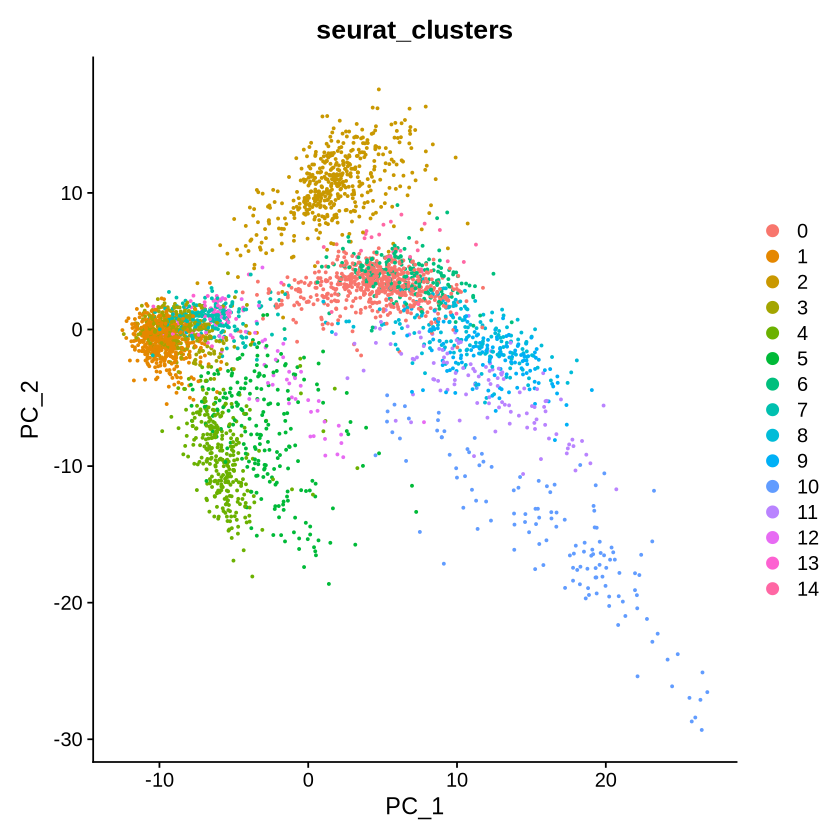

In [136]:
seurat_BC2_process = RunPCA(seurat_BC2_process , features = VariableFeatures(object = seurat_BC2_process)) # already found 2000 variable features
plot1 = DimPlot(seurat_BC2_process, reduction = "pca", group.by="orig.ident") 
seurat_BC2_process = FindNeighbors(seurat_BC2_process, dims = 1:20) 
seurat_BC2_process = FindClusters(seurat_BC2_process, resolution = 1)
seurat_BC2_process = BuildClusterTree(seurat_BC2_process)
# PlotClusterTree(seurat_BC2_process)
# plot the clusters
DimPlot(seurat_BC2_process, reduction = "pca", group.by="seurat_clusters")


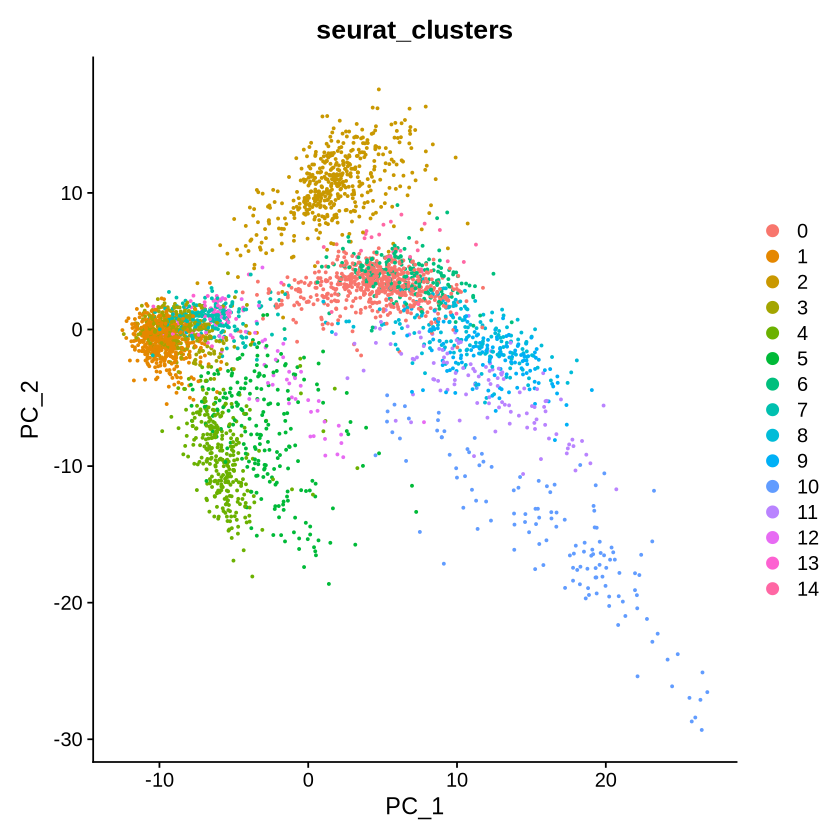

In [ ]:
seurat_BC2_process = RunPCA(seurat_BC2_process , features = VariableFeatures(object = seurat_BC2_process)) # already found 2000 variable features
plot1 = DimPlot(seurat_BC2_process, reduction = "pca", group.by="orig.ident") 
seurat_BC2_process = FindNeighbors(seurat_BC2_process, dims = 1:20) 
seurat_BC2_process = FindClusters(seurat_BC2_process, resolution = 1)
seurat_BC2_process = BuildClusterTree(seurat_BC2_process)
# PlotClusterTree(seurat_BC2_process)
# plot the clusters
DimPlot(seurat_BC2_process, reduction = "pca", group.by="seurat_clusters")


In [137]:
# seurat_BC2_process@reductions[["pca"]]@cell.embeddings
# ElbowPlot(seurat_BC2_process, ndims=50, reduction="pca") 

In [ ]:
# accounting for cell cycle effects (cc gene)
# cc.genes
g2m_genes = cc.genes$g2m.genes
g2m_genes = CaseMatch(search = g2m_genes, match = VariableFeatures(seurat_BC2_process))
s_genes = cc.genes$s.genes
s_genes = CaseMatch(search = s_genes, match = VariableFeatures(seurat_BC2_process))
seurat_BC2_process = CellCycleScoring(object=seurat_BC2_process,  g2m.features=g2m_genes,  s.features=s_genes)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
01:24:09 UMAP embedding parameters a = 0.9922 b = 1.112

01:24:09 Read 3648 rows and found 2000 numeric columns

01:24:09 Using Annoy for neighbor search, n_neighbors = 30

01:24:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:24:10 Writing NN index file to temp file /scratch/local/49525595/Rtmp4IIjQb/file2b9904439e2e67

01:24:10 Searching Annoy index using 1 thread, search_k = 3000

01:24:22 Annoy recall = 100%

01:24:22 Commencing smooth kNN distance calibration using 1 thread
 wi

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3648
Number of edges: 129616

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8457
Number of communities: 15
Elapsed time: 0 seconds


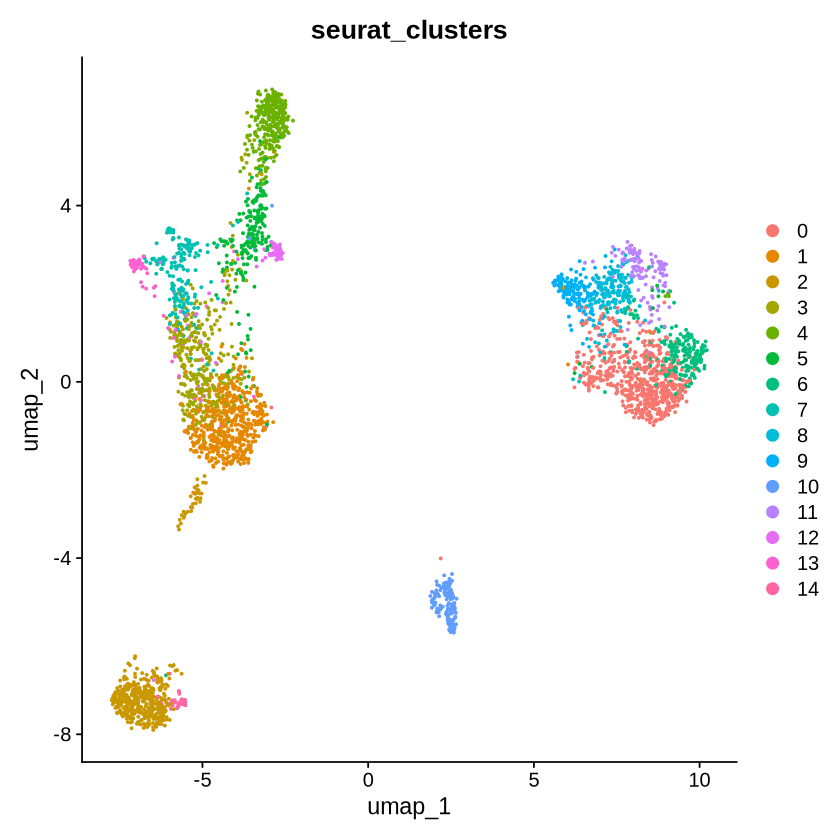

In [138]:
seurat_BC2_process = RunUMAP(seurat_BC2_process , features = VariableFeatures(object = seurat_BC2_process)) # already found 2000 variable features
plot1 = DimPlot(seurat_BC2_process, reduction = "umap", group.by="orig.ident") 
seurat_BC2_process = FindNeighbors(seurat_BC2_process, dims = 1:20) 
seurat_BC2_process = FindClusters(seurat_BC2_process, resolution = 1)
seurat_BC2_process = BuildClusterTree(seurat_BC2_process)
# PlotClusterTree(seurat_BC2_process)
# plot the clusters
DimPlot(seurat_BC2_process, reduction = "umap", group.by="seurat_clusters")


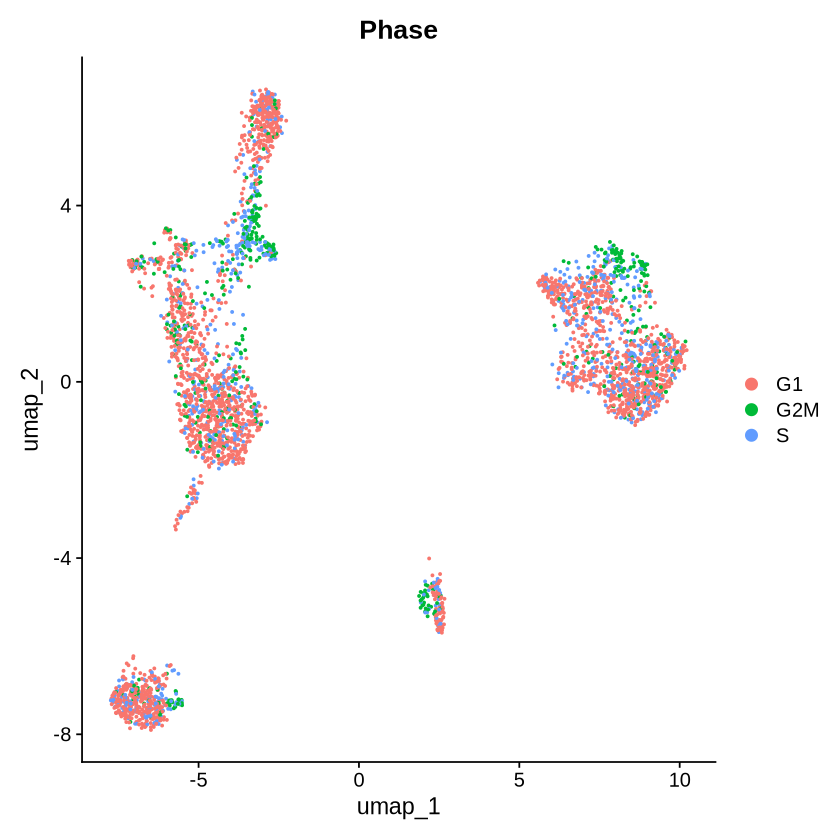

In [139]:
DimPlot(seurat_BC2_process, reduction = "umap", group.by = "Phase")

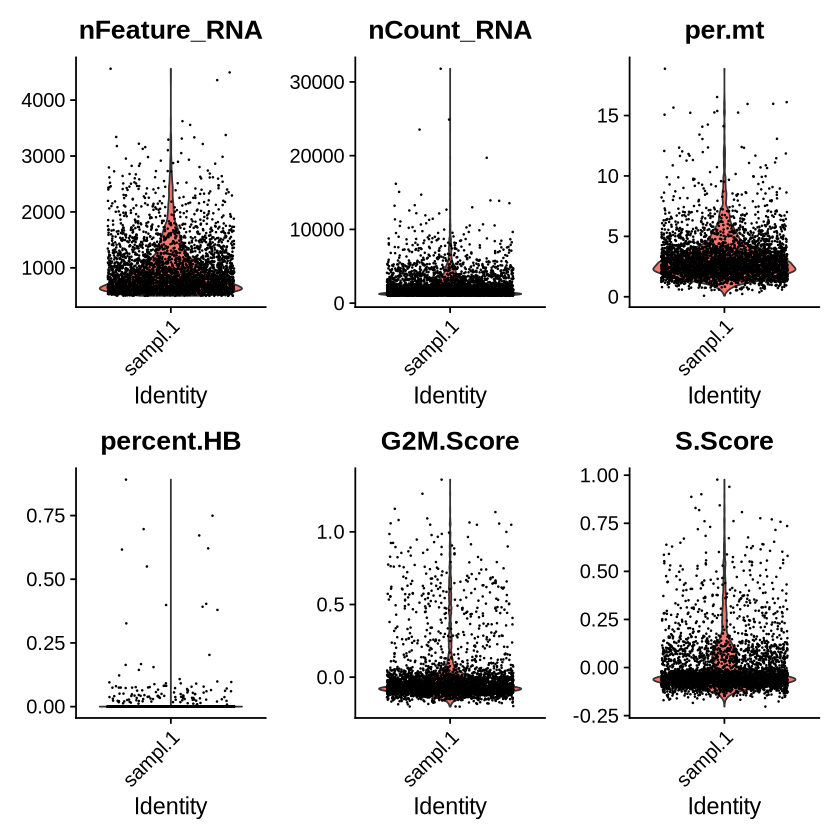

In [131]:
VlnPlot(seurat_BC2_process, features = c("nFeature_RNA", "nCount_RNA", "per.mt","percent.HB","G2M.Score","S.Score"), ncol = 3)